In [1]:
import numpy as np
import sciris as sc
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd
from scipy.linalg import lu, inv
from scipy.integrate import odeint, ODEintWarning
from scipy.interpolate import PchipInterpolator
import warnings
import seaborn as sns
from dataclasses import dataclass
from pyDOE import lhs

In [2]:
@dataclass
class Par:
    data: dict

    def to_dict(self):
        return self.data

    def __repr__(self):
        return str(self.data)

In [3]:
def generate_random_composition(bacteria_types, initial_biomass=1000, min_abundance=100):
    dominance_likelihoods = {
        'oLB': 0.10,
        'Li': 0.35,
        'nAB': 0.55,
    }

    # Ensure initial biomass is sufficient to meet minimum requirement for all bacteria
    total_min_abundance = min_abundance * len(bacteria_types)
    if initial_biomass < total_min_abundance:
        raise ValueError("Initial biomass is too low to meet the minimum abundance requirement for all bacteria.")

    # Choose a dominant bacterium based on likelihoods
    dominant_bacterium = np.random.choice(bacteria_types, p=[dominance_likelihoods[bt] for bt in bacteria_types])

    # Randomly assign a dominant proportion of remaining biomass
    dominant_proportion = np.random.uniform(0.6, 0.8)
    remaining_proportion = 1.0 - dominant_proportion

    # Allocate minimum abundance to each bacterium
    initial_allocations = {bt: min_abundance for bt in bacteria_types}
    remaining_biomass = initial_biomass - sum(initial_allocations.values())

    # Distribute remaining proportion among other bacteria
    other_bacteria = [bt for bt in bacteria_types if bt != dominant_bacterium]
    other_proportions = np.random.dirichlet(np.ones(len(other_bacteria))) * remaining_proportion

    # Adjust proportions to include minimum abundance
    proportions = {bt: initial_allocations[bt] / initial_biomass for bt in bacteria_types}
    proportions.update({bt: proportions[bt] + (prop * remaining_biomass / initial_biomass) for bt, prop in zip(other_bacteria, other_proportions)})
    proportions[dominant_bacterium] = (initial_allocations[dominant_bacterium] + (dominant_proportion * remaining_biomass)) / initial_biomass

    # Calculate absolute abundance
    absolute_abundance = {bt: proportions[bt] * initial_biomass for bt in bacteria_types}

    return proportions, absolute_abundance

In [4]:
def generate_composition_from_CST(CST, bacteria_types, initial_biomass=1000):
    # Mapping CST to the dominant bacterium
    dominant_mapping = {
        'CST I': 'oLB',
        'CST III': 'Li',
        'CST IV': 'nAB',
    }

    # Validate CST
    if CST not in dominant_mapping:
        raise ValueError(f"Unknown CST: {CST}. Expected one of {list(dominant_mapping.keys())}.")

    dominant_bacterium = dominant_mapping[CST]

    # Ensure dominant bacterium exists in bacteria_types
    if dominant_bacterium not in bacteria_types:
        raise ValueError(f"Dominant bacterium '{dominant_bacterium}' not found in bacteria_types.")

    # Determine dominant bacterium's proportion
    dominant_proportion = np.random.uniform(0.6, 0.9)
    remaining_proportion = 1.0 - dominant_proportion

    # Generate random proportions for remaining bacteria
    other_bacteria = [bt for bt in bacteria_types if bt != dominant_bacterium]
    other_proportions = np.random.dirichlet(np.ones(len(other_bacteria))) * remaining_proportion

    # Create proportions dictionary
    proportions = {bt: float(prop) for bt, prop in zip(other_bacteria, other_proportions)}
    proportions[dominant_bacterium] = dominant_proportion

    # Calculate absolute abundance based on initial biomass
    absolute_abundance = {bt: proportions[bt] * initial_biomass for bt in bacteria_types}

    return proportions, absolute_abundance

In [5]:
external_parameters_distribution = sc.objdict(
    menstrual_hygiene = sc.objdict(
        products = Par(data={'cup': 0.05, 'single_use': 0.4, 'reusable_homemade': 0.35, 'reusable_manufactured': 0.2}),  # could be adjusted for urbanicity/SES
        # Weighted likelihoods: if you use a reusable homemade product higher likelihood you have poor WASH access and are prone to overuse
        WASH = sc.objdict(
            cup = Par(data={'good': 0.6, 'medium': 0.3, 'poor': 0.1}),
            single_use = Par(data={'good': 0.7, 'medium': 0.2, 'poor': 0.1}),
            reusable_homemade = Par(data={'good': 0.1, 'medium': 0.3, 'poor': 0.6}),  # Higher likelihood of poor WASH access
            reusable_manufactured = Par(data={'good': 0.4, 'medium': 0.3, 'poor': 0.3})
        ),
        # normal = appropriate change rate, over = uLile to change at appropriate rate
        use = sc.objdict(
            cup = Par(data={'normal': 0.6, 'over': 0.4}),
            single_use = Par(data={'normal': 0.7, 'over': 0.3}),
            reusable_homemade = Par(data={'normal': 0.3, 'over': 0.7}),  # Higher likelihood of overuse
            reusable_manufactured = Par(data={'normal': 0.6, 'over': 0.4})
        ),
        # Borzutzky & Jaffray, 2019 2. CDC – Heavy Menstrual Bleeding 3. O'Brien et al., 2019; Vo et al., 2013 4. Sinharoy et al. 2024
        flow = Par(data={'light': 0.25, 'medium': 0.25, 'heavy': 0.5})
    ),
    sex_practices = sc.objdict(
        condom_use = Par(data={'yes': 0.39, 'no': 0.61}),
        circumcision_status = Par(data={'yes': 0.49, 'no': 0.51}),
    ),
    birth_control = Par(data={'iud': 0.1, 'DEPO': 0.2, 'pill': 0.15, 'condom': 0.25, 'none': 0.3}),  # rough estimates
    antibiotics = Par(data={'yes': 0.1}),  # Probability of taking antibiotics
    bacteria_types = ['nAB', 'Li', 'oLB']
)

In [6]:
def choose(par):
    if isinstance(par, Par):
        par = par.to_dict()  # Convert Par object to dictionary if necessary with nested wash/use parameters

    a, p = zip(*par.items())  # Unpack keys and values
    p = np.array(p, dtype=float)
    p /= p.sum()  # Normalize to sum to 1

    if not np.isclose(p.sum(), 1.0):
        raise ValueError(f'Probabilities for {a} do not sum to 1: {p.sum()}')

    return np.random.choice(a, p=p)

In [7]:
def calculate_penile_abundance(agent):
    abundance = 100 # about 1/10 to 1/100 of VMB absolute abundance based on brief lit search

    # Adjust absolute abundance based on circumcision status
    if agent.circumcision_status == 'no':
        abundance *= 1.5  # Increase if uncircumcised

    # Adjust abundance based on WASH status
    wash_multiplier = {
        'poor': 1.5,  # Further increase if hygiene is poor
        'medium': 1.2,  # Moderate increase if hygiene is medium
        'good': 1.0  # No change if hygiene is good
    }
    abundance *= wash_multiplier.get(agent.WASH, 1.0)  # Default to 1.0 if WASH is not recognized
    #print(f"Penile abundance: {abundance}")
    return abundance

In [8]:
# From original LHS fRom Lee https://doi.org/10.1371/journal.pcbi.1011295
def generate_interaction_param():
    interaction_params = [
        np.random.uniform(0.1, 1),  # Growth rate of non-optimal bacteria (nAB)
        np.random.uniform(0.1, 1),  # Growth rate of Lactobacillus iners (Li)
        np.random.uniform(0.1, 1),  # Growth rate of optimal Lactobacillus (oLB)
        np.random.uniform(-0.04, -0.004),  # Self-interaction of nAB (how it affects itself)
        np.random.uniform(-0.12, 0.12),    # Interaction of nAB on Li (how nAB affects Li)
        np.random.uniform(-0.12, 0.12),    # Interaction of nAB on oLB (how nAB affects oLB)
        np.random.uniform(-0.12, 0.12),    # Interaction of Li on nAB (how Li affects nAB)
        np.random.uniform(-0.04, -0.004),    # Self-interaction of Li (how Li affects itself) # changed to match the other self interaction terms
        np.random.uniform(-0.12, 0.12),    # Interaction of Li on oLB (how Li affects oLB)
        np.random.uniform(-0.12, 0.00),    # Interaction of oLB on nAB (how oLB affects nAB)
        np.random.uniform(-0.12, 0.12),    # Interaction of oLB on Li (how oLB affects Li)
        np.random.uniform(-0.04, -0.004)   # Self-interaction of oLB (how oLB affects itself)
    ]
    #print(f"Generated interaction parameters: {interaction_params}")  # print out interaction parameters
    return interaction_params

In [9]:
# Remove x values that are not increasing and corresponding y values
# Because of dynamic cycle eval points that are adjusted based on agent specific menstrual cycle, sometimes cycle eval points are not increasing
def remove_non_increasing_points(x, y):
    increasing_indices = np.where(np.diff(x) > 0)[0] + 1  # Identify strictly increasing points
    increasing_indices = np.insert(increasing_indices, 0, 0)  # Include the first point

    x_filtered = np.array(x)[increasing_indices]
    y_filtered = np.array(y)[increasing_indices]

    return x_filtered, y_filtered

In [10]:
class Agent:
    def __init__(self, external_parameters_distribution,
                 bacteria_types=None,
                 CST=None,
                 products='random',
                 WASH='random',
                 use='random',
                 flow=None,
                 condom_use='random',
                 circumcision_status='random',
                 birth_control='random',
                 sexually_active='random',
                 has_menstrual_cycle=True,
                 generate_interaction_params=True):
        self.external_parameters_distribution = external_parameters_distribution
        self.has_menstrual_cycle = has_menstrual_cycle
        self.menstruation_phase = None

        # Initialize interaction parameters
        self.interaction_params = generate_interaction_param() if generate_interaction_params else None

        # Initialize bacterial proportions and absolute abundance
        if CST:
            self.proportions, self.absolute_abundance = generate_composition_from_CST(CST, external_parameters_distribution['bacteria_types'])
        else:
            self.proportions, self.absolute_abundance = generate_random_composition(external_parameters_distribution['bacteria_types'])
            self.CST = self.assign_CST()  # Corrected to not pass proportions as an argument

        # Assign characteristics using the provided distributions or randomly
        self.products = self.assign_characteristic(products, external_parameters_distribution['menstrual_hygiene'].products.to_dict(), allow_none=True)
        self.WASH = self.assign_characteristic(WASH, external_parameters_distribution['menstrual_hygiene'].WASH[self.products].to_dict(), allow_none=True)
        self.use = self.assign_characteristic(use, external_parameters_distribution['menstrual_hygiene'].use[self.products].to_dict(), allow_none=True)
        self.flow = self.assign_characteristic(flow, external_parameters_distribution['menstrual_hygiene'].flow.to_dict(), allow_none=True)
        self.condom_use = self.assign_characteristic(condom_use, external_parameters_distribution['sex_practices'].condom_use.to_dict(), allow_none=True)
        self.circumcision_status = self.assign_characteristic(circumcision_status, external_parameters_distribution['sex_practices'].circumcision_status.to_dict(), allow_none=True)
        self.birth_control = self.assign_characteristic(birth_control, external_parameters_distribution['birth_control'].to_dict(), allow_none=True)
        self.sexually_active = self.assign_characteristic(sexually_active, {'yes': 0.8, 'no': 0.2}) if sexually_active == 'random' else sexually_active

        # Calculate penile abundance based on circumcision and WASH status
        self.penile_abundance = calculate_penile_abundance(self)

        # Initialize menstrual cycle and related events
        self.menstrual_day = 1
        self.menstruation_duration = random.randint(2, 7)
        self.ovulation_duration = 1

        # Ensure total cycle length is between 22 and 35 days
        min_total_cycle_length = 22
        max_total_cycle_length = 35
        min_remaining_days = min_total_cycle_length - (self.menstruation_duration + self.ovulation_duration)
        max_remaining_days = max_total_cycle_length - (self.menstruation_duration + self.ovulation_duration)

        # Assign days to follicular and luteal phases
        self.follicular_duration = random.randint(11, min(27, max_remaining_days - 11))
        self.luteal_duration = max_remaining_days - self.follicular_duration

        # Calculate total cycle length
        self.cycle_length = self.menstruation_duration + self.follicular_duration + self.ovulation_duration + self.luteal_duration

        # Initialize hormone levels for current day
        self.estrogen_level = 0
        self.progesterone_level = 0

        # Precompute hormone levels for the entire cycle
        self.precompute_hormone_levels()

        # Initialize pH & compute pH levels for entire cycle
        #self.vaginal_pH = 0
        self.precompute_vaginal_pH()

        self.sexual_events = self.generate_sexual_events()
        self.last_antibiotic_day = -15

    # Debugging: print cycle durations
    #print(f'Menstruation duration: {self.menstruation_duration}, Follicular duration: {self.follicular_duration}, Luteal duration: {self.luteal_duration}')

    def assign_characteristic(self, characteristic, distribution, allow_none=False):
        if characteristic == 'random':
            return np.random.choice(list(distribution.keys()), p=list(distribution.values()))
        if characteristic is None and allow_none:
            return None
        return characteristic

    def precompute_hormone_levels(self):
        # Define more key points in the cycle for better accuracy, including extra points for estrogen and progesterone
        cycle_eval_points = [
            1,  # Start of menstruation
            self.menstruation_duration,  # End of menstruation (Days 5-7)
            self.menstruation_duration + (self.follicular_duration / 6),  # Extra low point before estrogen climb
            self.menstruation_duration + (self.follicular_duration / 3),  # Extra point before estrogen climb
            self.menstruation_duration + (self.follicular_duration / 2),  # Mid-follicular phase
            self.menstruation_duration + self.follicular_duration - 1,  # End of follicular phase, just before ovulation
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration,  # Ovulation
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration + (self.luteal_duration / 6),  # Early luteal
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration + (self.luteal_duration / 3),  # Mid-luteal (plateau start)
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration + (self.luteal_duration / 2),  # Plateau
            self.cycle_length  # End of luteal (End of cycle)
        ]

        # Fine-tune estrogen values based on lit search (dg/mL)
        estrogen_values = [
            2.0,   # Low during menstruation
            2.0,   # Low at end of menstruation
            2.0,   # Extra low point before the climb
            5.0,   # Extra point before the climb
            15.0,  # Late follicular (steep rise) peak
            35.0,  # Decline start ovulation
            10.0,  # Decline after ovulation
            10.0,  # Early luteal
            15.0,  # Mid-luteal decline
            15.0,   # Late luteal decline
            2.0    # End of luteal phase (back to low)
        ]

        # Fine-tune estrogen values based on lit search (ng/mL)
        progesterone_values = [
            0.1,  # Low during menstruation and follicular
            0.1,  # Low end of menstruation
            0.1,  # Early follicular (remains low)
            0.1,  # Mid-follicular (still low)
            3.0,  # Ovulation
            5.0, # Early luteal sharp rise
            5.0, # Mid-luteal peak
            10.0, # Plateau at peak in luteal
            18.0, # Plateau at peak in luteal
            18.0,  # Late luteal decline
            1.8   # End of luteal phase sharp drop
        ]

        # Ensure cycle_eval_points is strictly increasing
        cycle_eval_points, estrogen_values = remove_non_increasing_points(cycle_eval_points, estrogen_values)
        cycle_eval_points, progesterone_values = remove_non_increasing_points(cycle_eval_points, progesterone_values)

        # Use smoother curves
        estrogen_spline = PchipInterpolator(cycle_eval_points, estrogen_values)
        progesterone_spline = PchipInterpolator(cycle_eval_points, progesterone_values)

        self.days_full = np.arange(0, self.cycle_length)
        self.estrogen_levels = estrogen_spline(self.days_full)
        self.progesterone_levels = progesterone_spline(self.days_full)

        # Ensure no negative progesterone values
        self.progesterone_levels = np.clip(self.progesterone_levels, 0, None)

    def get_hormone_levels_for_day(self):
        # Retrieve the estrogen and progesterone levels for the current menstrual day directly.
        self.estrogen_level = self.estrogen_levels[self.menstrual_day - 1]
        self.progesterone_level = self.progesterone_levels[self.menstrual_day - 1]
        return self.estrogen_level, self.progesterone_level

    def precompute_vaginal_pH(self):
        # Define key points in the cycle based on the agent's menstrual phase durations
        cycle_eval_points = [
            1,  # Start of menstruation
            self.menstruation_duration / 2,  # mid menstruation peak
            self.menstruation_duration, # End of menstruation
            self.menstruation_duration + 1, # Beginning of follicular large drop
            self.menstruation_duration + (self.follicular_duration / 2),  # Extra point mid-follicular
            self.menstruation_duration + self.follicular_duration,  # Follicular
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration,  # Ovulation
            self.menstruation_duration + self.follicular_duration + self.ovulation_duration + (self.luteal_duration / 2),  # Mid-luteal
            self.cycle_length  # End of luteal (End of cycle)
        ]

        # Define the corresponding vaginal pH values for these key points in the cycle
        pH_values = [
            6,  # High pH at the start of menstruation
            6.8,  # Peak pH mid menstruation
            5.5,  # Lowering pH by the end of menstruation
            4.4,  # Stable low pH in beginning of follicular phase
            4.0, # Stable low pH mid-follicular
            4.0,  # Stable low pH end of follicular phase
            3.9, # Stable low pH ovulation
            3.9, #Stable low pH mid-luteal
            3.8,  # Stable low rest of cycle
        ]

        # Ensure cycle_eval_points is strictly increasing
        cycle_eval_points, pH_values = remove_non_increasing_points(cycle_eval_points, pH_values)

        # Interpolate pH changes using cubic spline
        pH_spline = PchipInterpolator(cycle_eval_points, pH_values)

        # Generate smooth pH levels across entire cycle
        self.vaginal_pH = pH_spline(self.days_full)

        return self.vaginal_pH

    def get_pH_levels_for_day(self):
        # Retrieve the pH level for current menstrual day directly.
        self.vaginal_pH_day = self.vaginal_pH[self.menstrual_day - 1]
        return self.vaginal_pH_day

    def update_menstrual_phase(self):
        #Update the agent's menstrual phase and hormone levels based on the current day in the cycle.
        if not self.has_menstrual_cycle:
            self.menstruation_phase = 'no cycle'
            self.menstrual_day = 0
            return

        if self.menstrual_day < self.menstruation_duration:
            self.menstruation_phase = 'menstruation'
        elif self.menstrual_day < self.menstruation_duration + self.follicular_duration:
            self.menstruation_phase = 'follicular'
        elif self.menstrual_day < self.menstruation_duration + self.follicular_duration + self.ovulation_duration:
            self.menstruation_phase = 'ovulation'
        else:
            self.menstruation_phase = 'luteal'

        # Increment menstrual day
        self.menstrual_day += 1

        # Reset menstrual day if it exceeds the cycle length
        if self.menstrual_day > self.cycle_length:
            self.menstrual_day = 1

        # Update hormone levels for the current day
        self.get_hormone_levels_for_day()
        self.get_pH_levels_for_day()

    def generate_sexual_events(self):
        if self.sexually_active:
            num_events = random.randint(4, 15)
            return random.sample(range(1, 29), num_events)
        return []
    def random_sexual_event(self):
        return (self.menstrual_day % 28) in self.sexual_events

    def random_antibiotic_use(self):
        if self.menstrual_day - self.last_antibiotic_day >= 14:
            if random.random() < self.external_parameters_distribution['antibiotics'].to_dict()['yes']:
                self.last_antibiotic_day = self.menstrual_day
                #print(f'Antibiotic used on day {self.menstrual_day}, nAB set to 0.')
                return True
        return False

    def assign_CST(self):
        dominant_bacterium = max(self.proportions, key=self.proportions.get)
        self.CST = {
            'oLB': 'CST I',
            'Li': 'CST III',
            'nAB': 'CST IV',
        }.get(dominant_bacterium, 'Unknown CST')
        return self.CST

    def adjust_rates(self, time_step, external_parameters_distribution):
        adjust_rates(self, time_step, external_parameters_distribution)

    def __str__(self):
        return (f'Agent with CST: {self.CST}\n'
                f'Bacterial Composition: {self.proportions}\n'
                f'Menstrual Products: {self.products}\n'
                f'WASH: {self.WASH}\n'
                f'Use: {self.use}\n'
                f'Flow: {self.flow}\n'
                f'Condom Use: {self.condom_use}\n'
                f'Circumcision Status: {self.circumcision_status}\n'
                f'Birth Control: {self.birth_control}\n'
                f'Sexually Active: {self.sexually_active}\n'
                f'Menstrual Day: {self.menstrual_day}\n'
                f'Sexual Events: {self.sexual_events}\n'
                f'Estrogen Level: {self.estrogen_level}\n'
                f'Progesterone Level: {self.progesterone_level}\n'
                f'Has Menstrual Cycle: {self.has_menstrual_cycle}')
    def print_cycle_durations(self):
        print(f"Menstruation Duration: {self.menstruation_duration} days")
        print(f"Follicular Duration: {self.follicular_duration} days")
        print(f"Ovulation Duration: {self.ovulation_duration} days")
        print(f"Luteal Duration: {self.luteal_duration} days")
        print(f"Total Cycle Length: {self.cycle_length} days")

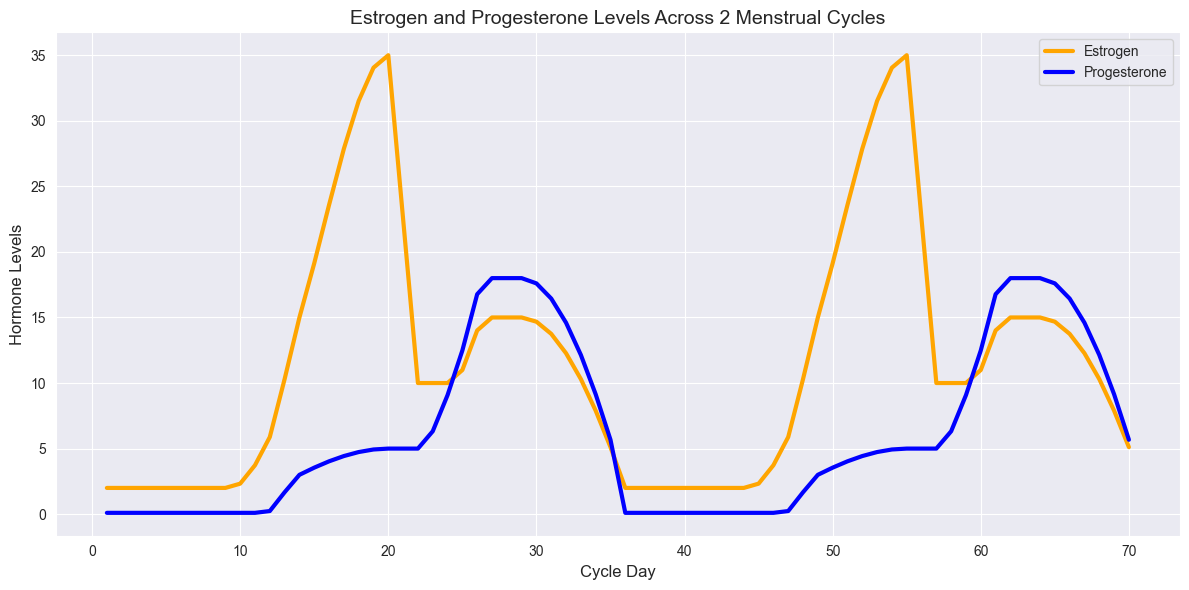

In [11]:
def plot_hormone_levels(agent, num_cycles):
    # Retrieve precomputed estrogen and progesterone levels for one cycle
    estrogen_levels_single_cycle = agent.estrogen_levels
    progesterone_levels_single_cycle = agent.progesterone_levels

    # Repeat the hormone levels across the number of cycles
    estrogen_levels = np.tile(estrogen_levels_single_cycle, num_cycles)
    progesterone_levels = np.tile(progesterone_levels_single_cycle, num_cycles)

    # Calculate the total number of days across all cycles
    total_days = agent.cycle_length * num_cycles
    cycle_eval_points = np.arange(1, total_days + 1)

    plt.figure(figsize=(12, 6))

    # Plot estrogen and progesterone levels
    plt.plot(cycle_eval_points, estrogen_levels, label='Estrogen', color='orange', linewidth=3)
    plt.plot(cycle_eval_points, progesterone_levels, label='Progesterone', color='blue', linewidth=3)

    plt.xlabel('Cycle Day', fontsize=12)
    plt.ylabel('Hormone Levels', fontsize=12)
    plt.title(f'Estrogen and Progesterone Levels Across {num_cycles} Menstrual Cycles', fontsize=14)
    plt.legend()

    plt.tight_layout()
    plt.show()

agent = Agent(external_parameters_distribution)

plot_hormone_levels(agent, num_cycles=2)

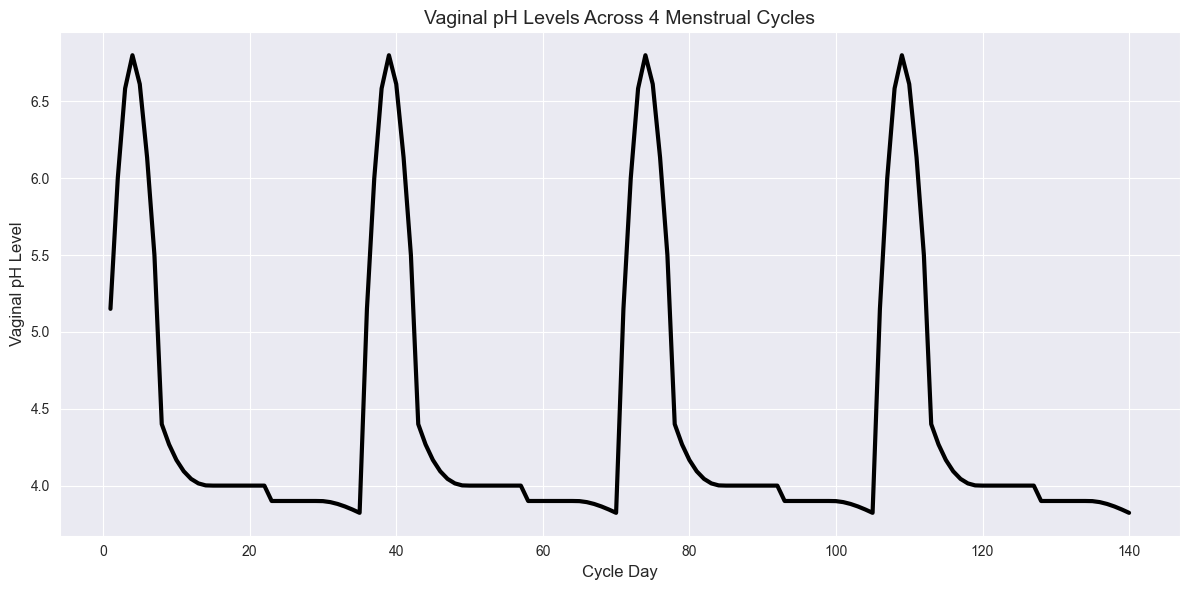

In [12]:
def plot_vaginal_pH(agent, num_cycles):
    # Retrieve precomputed vaginal pH levels for one cycle
    pH_levels_single_cycle = agent.vaginal_pH

    # Repeat the pH levels across the number of cycles
    pH_levels = np.tile(pH_levels_single_cycle, num_cycles)

    # Calculate the total number of days across all cycles
    total_days = agent.cycle_length * num_cycles
    cycle_eval_points = np.arange(1, total_days + 1)

    plt.figure(figsize=(12, 6))

    # Plot vaginal pH levels
    plt.plot(cycle_eval_points, pH_levels, label='Vaginal pH', color='black', linewidth=3)

    plt.xlabel('Cycle Day', fontsize=12)
    plt.ylabel('Vaginal pH Level', fontsize=12)
    plt.title(f'Vaginal pH Levels Across {num_cycles} Menstrual Cycles', fontsize=14)

    plt.tight_layout()
    plt.show()

agent = Agent(external_parameters_distribution)

# Plot vaginal pH levels across 2 menstrual cycles
plot_vaginal_pH(agent, num_cycles=4)

In [13]:
def adjust_rates(agent, time_step, external_parameters_distribution):
    # Extract bacteria types
    bacteria_types = external_parameters_distribution['bacteria_types']

    # Get current hormone levels and pH for agent
    estrogen_level, progesterone_level = agent.get_hormone_levels_for_day()
    vaginal_pH = agent.get_pH_levels_for_day()

    # Initialize replication adjustment dictionary
    replication_adjustment = {bacterium: 0 for bacterium in bacteria_types}

    # Hormone effects on bacterial growth
    # Positive correlation between estrogen and oLB (Lactobacillus crispatus) --> r value from Danish paper
    replication_adjustment['oLB'] = 0.11 * (estrogen_level - np.mean(agent.estrogen_levels)) / np.std(agent.estrogen_levels)

    # Progesterone impacts mucin production, which affects nAB and Li growth rates
    progesterone_scaling_factor = 0.05 * (progesterone_level - np.mean(agent.progesterone_levels)) / np.std(agent.progesterone_levels)
    replication_adjustment['nAB'] = progesterone_scaling_factor
    replication_adjustment['Li'] = progesterone_scaling_factor

    # pH impact on bacterial growth rates based on Spearman correlations
    # Lactobacillus crispatus (oLB) negatively correlated with pH (-0.307)
    replication_adjustment['oLB'] += -0.307 * (vaginal_pH - 4.0)

    # Non-Lactobacillus bacteria (Prevotella/Gardnerella - nAB) positively correlated with pH (0.274 and 0.272)
    replication_adjustment['nAB'] += 0.273 * (vaginal_pH - 4.0)

    # Max growth rate cap
    max_growth_rate = 2.5

    for i, bacterium in enumerate(['nAB', 'Li', 'oLB']):
        if isinstance(agent.interaction_params[i], np.ndarray):
            interaction_param = agent.interaction_params[i].item()
        else:
            interaction_param = agent.interaction_params[i]

        # Adjust growth rates by interaction params and replication adjustments from hormones and pH
        adjusted_growth_rate = interaction_param + replication_adjustment[bacterium]

        # Apply min() and max() to values
        agent.interaction_params[i] = min(max(adjusted_growth_rate, 0), max_growth_rate)

    return agent.interaction_params

In [14]:
def sim_continuous(X0, t_span, agent, time_step=1):
    if np.isscalar(t_span):
        t_span = [0, t_span]

    def lotka_volterra(x, t):
        # Update interaction parameters dynamically
        interaction_matrix = np.array(agent.interaction_params[3:]).reshape(3, 3)
        adjusted_r = np.array(agent.interaction_params[:3])  # Only the first 3 for 3 species

        # Inversely scale the interaction matrix by the initial total biomass of the agent
        total_biomass = np.sum(X0)
        scaled_interaction_matrix = interaction_matrix / total_biomass

        return (adjusted_r * x) + np.dot(scaled_interaction_matrix, x) * x

    times = []
    results = []
    current_time = t_span[0]
    current_state = X0

    while current_time < t_span[1]:
        # Update the agent's menstrual phase
        agent.update_menstrual_phase()

        # External factors impact the abundance directly (before applying gLV dynamics)
        nAB, Li, oLB = current_state

        '''
        # Apply reduction in oLB only on the first day of menstruation
        if agent.menstruation_phase == 'menstruation' and agent.menstrual_day == 1:
            oLB *= 0.5  # Halve oLB abundance on the first day of menstruation

        if agent.random_antibiotic_use():
            nAB *= 0.05  # Drastic reduction in nAB due to antibiotic use

        # Sexual events introduce nAB biomass directly
        if agent.random_sexual_event():
            transfer_factor = 0.2 if agent.condom_use == 'no' else 0.1
            nAB += agent.penile_abundance * transfer_factor
        '''

        # Update the state after the direct modifications
        current_state = np.array([nAB, Li, oLB])

        # Simulate over one time step
        t_eval = [current_time, current_time + time_step]
        sol, infodict = odeint(lotka_volterra, current_state, t_eval, hmax=1e-3, full_output=1)  # hmax limits maximum step size
        '''
        # Debugging: Check for issues with the solver
        if infodict['message'] != 'Integration successful.':
            print(f"Integration issue at time {current_time}: {infodict['message']}")
        '''
        # Adjust growth rates and interaction parameters based on current physiology
        # Assumption there is delayed impact on growth instead of immediate
        agent.adjust_rates(time_step, agent.external_parameters_distribution)

        # Update time and state
        current_time += time_step
        current_state = sol[-1]  # Last row of the solution = updated state

        # Store results
        times.extend(t_eval)
        results.extend(sol)

    return np.array(times), np.array(results).T

In [15]:
def plot_basic(T, X, ax, title=None, **kwargs):
    species_labels = ['nAB', 'Li', 'oLB']  # Labels for the three species
    ax.set_prop_cycle(None)  # Reset color cycle
    for i, label in enumerate(species_labels):
        ax.plot(T, X[i], label=label, **kwargs)
    ax.set_xlabel('Time')
    ax.set_ylabel('Abundance')
    ax.set_title(title)
    ax.legend()

/var/folders/b0/sf3ml2gd5rj8_kfk925pq1180000gn/T/ipykernel_79997/2314518142.py:47: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol, infodict = odeint(lotka_volterra, current_state, t_eval, hmax=1e-3, full_output=1)  # hmax limits maximum step size


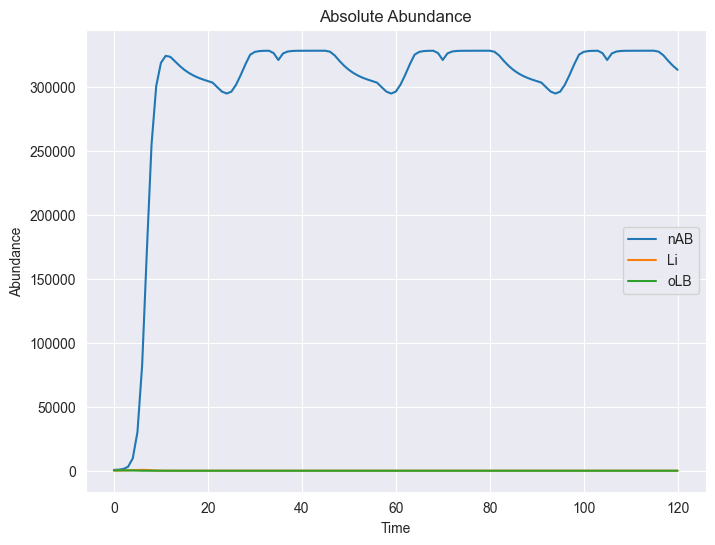

In [16]:
# Initialize agent
agent = Agent(external_parameters_distribution)

# Extract initial abundances from agent's absolute abundance dictionary
X0 = np.array([agent.absolute_abundance[species] for species in ['nAB', 'Li', 'oLB']])

# Simulate
T, X = sim_continuous(X0, t_span=120, agent=agent)

# Plot absolute abundance results
fig, ax = plt.subplots(figsize=(8, 6))
plot_basic(T, X, ax, title='Absolute Abundance')

plt.show()

In [17]:
def calculate_relative_abundance(X):
    species_labels = ['nAB', 'Li', 'oLB']
    total_abundance = X.sum(axis=0)  # Sum abundances across species at each time point

    relative_abundance_dict = {}

    # Iterate over species calculate relative abundance
    for i, label in enumerate(species_labels):
        relative_abundance = X[i] / total_abundance  # Calculate relative abundance for each species
        relative_abundance_dict[label] = relative_abundance  # Store in dictionary

    return relative_abundance_dict

In [18]:
def plot_relative_abundance(T, X):
    species_labels = ['nAB', 'Li', 'oLB']
    relative_abundance_dict = calculate_relative_abundance(X)

    # Plot relative abundances
    fig, ax = plt.subplots(figsize=(8, 6))

    # Debugging: Check lengths of time and relative abundances
    print(f"Length of T (time points): {len(T)}")

    # Iterate over species labels and plot corresponding relative abundances
    for species in species_labels:
        relative_abundance = relative_abundance_dict[species]
        print(f"Length of relative abundance for {species}: {len(relative_abundance)}")

        # Ensure relative abundance and time array lengths match
        if len(T) != len(relative_abundance):
            raise ValueError(f"Length mismatch: {species} relative abundance has length {len(relative_abundance)}, but T has length {len(T)}.")

        # Plot each species' relative abundance over time
        ax.plot(T, relative_abundance, label=species)

    ax.set_title('Relative Abundance Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('Relative Abundance')
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.show()

def assign_cst(T, X, thresholds):
    relative_abundance_dict = calculate_relative_abundance(X)

    nAB_abundance = relative_abundance_dict['nAB']
    Li_abundance = relative_abundance_dict['Li']
    oLB_abundance = relative_abundance_dict['oLB']

    csts = []

    # Iterate over each time point and assign CST based on abundance thresholds
    for i in range(len(T)):  # Loop over each time point
        if nAB_abundance[i] >= thresholds['nAB']:
            csts.append('CST IV')
        elif Li_abundance[i] >= thresholds['Li']:
            csts.append('CST III')
        elif oLB_abundance[i] >= thresholds['oLB']:
            csts.append('CST I')
        else:
            csts.append('No Dominant Bacterium')
    return csts

# Plotting function for CST
def plot_cst(T, csts):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(T, csts, marker='o', color = 'black')
    ax.set_title('CST Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel('CST')
    plt.xticks(rotation=90)
    plt.show()

# Bacterial thresholds for CSTs
thresholds = {
    'oLB': 0.6,
    'Li': 0.6,
    'nAB': 0.6
}

Length of T (time points): 240
Length of relative abundance for nAB: 240
Length of relative abundance for Li: 240
Length of relative abundance for oLB: 240


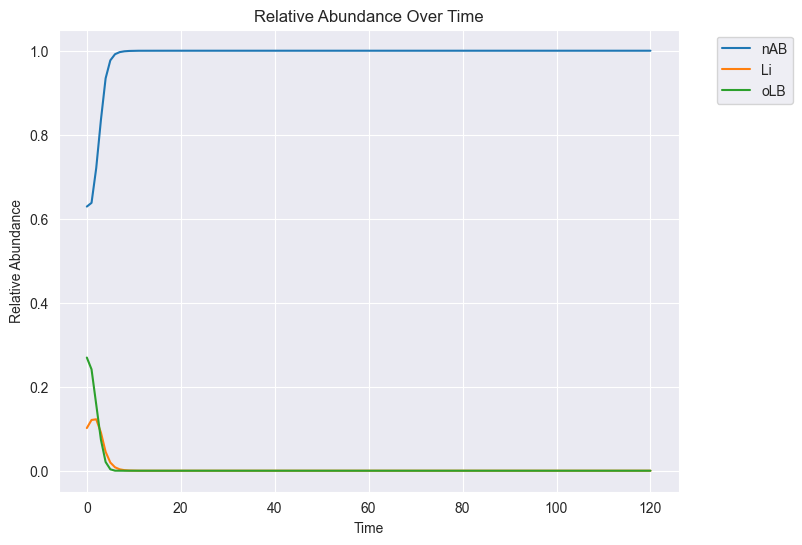

None


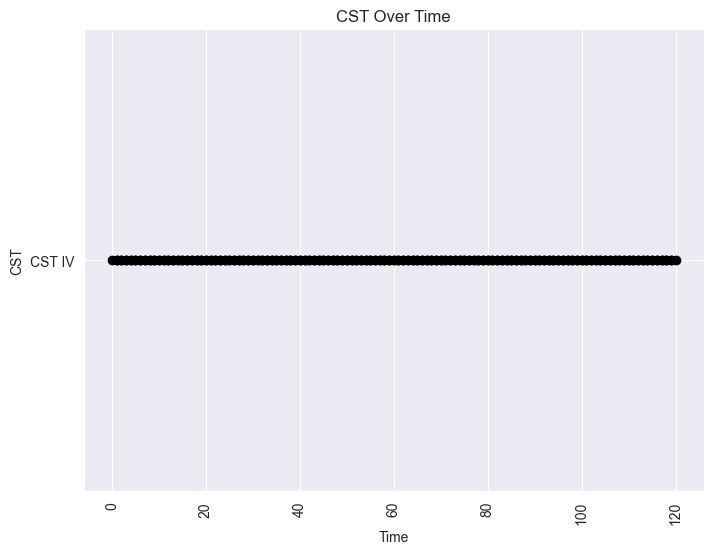

None


In [19]:
# Initialize the agent
#agent = Agent(external_parameters_distribution)

# Extract initial abundances from the agent's absolute abundance dictionary
#X0 = np.array([agent.absolute_abundance[species] for species in ['nAB', 'Li', 'oLB']])

# Simulate over 90 time units
#T, X = sim_continuous(X0, t_span=90, agent=agent)
print(plot_relative_abundance(T, X))
csts = assign_cst(T, X, thresholds)
print(plot_cst(T, csts))

In [ ]:
#Function to subsample CSTs every X number of days
def plot_cst_every_x_days(T, csts, x):
    # Subsample time points and CST values at intervals of x days
    T_subsampled = T[::x]
    csts_subsampled = csts[::x]

    # Plot the CST over subsampled time points
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(T_subsampled, csts_subsampled, marker='o', linestyle='-', color='black')
    ax.set_title(f'CST Every {x} Days')
    ax.set_xlabel('Time (days)')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plot_cst_every_x_days(T, csts, x=14)